Python environment:

- Version: 3.10
- environment managment: `pipenv`


In [71]:
import pandas as pd, pyreadr, warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf, numpy as np


from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


warnings.filterwarnings("ignore")

Variable Description:

- occ : Occupational classification
- ind : Industry classification
- lwage : Log hourly wage
- sex : Gender (1 female) (0 male)
- shs : Some high school
- hsg : High school graduated
- scl : Some College
- clg: College Graduate
- ad: Advanced Degree
- ne: Northeast
- mw: Midwest
- so: South
- we: West
- exp1: Experience


In [87]:
rdata = pyreadr.read_r("../wage2015_subsample_inference.Rdata")
rdata.keys()  # https://dl.ubnt.com/RouterStationChallenge/PyCI/docs/PyCI/odict.html

odict_keys(['data'])

In [88]:
data: pd.DataFrame = rdata["data"].reset_index()
data.sample(3)

,rownames,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,...,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
2223,12992,28.846154,3.361977,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,21.5,4.6225,9.938375,21.367506,6840,19,380,2
2626,15590,21.634615,3.074295,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,19.0,3.6100,6.859000,13.032100,2310,8,7860,17
2376,13866,18.750000,2.931194,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,9.0,0.8100,0.729000,0.656100,8810,21,3980,6


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150 entries, 0 to 5149
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   rownames  5150 non-null   object  
 1   wage      5150 non-null   float64 
 2   lwage     5150 non-null   float64 
 3   sex       5150 non-null   float64 
 4   shs       5150 non-null   float64 
 5   hsg       5150 non-null   float64 
 6   scl       5150 non-null   float64 
 7   clg       5150 non-null   float64 
 8   ad        5150 non-null   float64 
 9   mw        5150 non-null   float64 
 10  so        5150 non-null   float64 
 11  we        5150 non-null   float64 
 12  ne        5150 non-null   float64 
 13  exp1      5150 non-null   float64 
 14  exp2      5150 non-null   float64 
 15  exp3      5150 non-null   float64 
 16  exp4      5150 non-null   float64 
 17  occ       5150 non-null   category
 18  occ2      5150 non-null   category
 19  ind       5150 non-null   category
 20  ind2    

In [6]:
# Filtering data to focus on college-advanced-educated workers
data_filtered = data.query("scl == 1 | clg == 1 | ad == 1")
n_data = len(data_filtered)
data_filtered

,rownames,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,...,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
0,10,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
1,12,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9
3,18,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12
4,19,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22
5,30,11.730769,2.462215,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.01,0.001,0.0001,1650,5,7460,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,32619,13.846154,2.628007,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,10.0,1.00,1.000,1.0000,800,2,770,4
5145,32620,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9
5146,32624,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20
5147,32626,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6


# Plots


In [7]:
main_variables = ["wage", "lwage", "sex", "scl", "clg", "ad", "exp1"]

<Axes: >

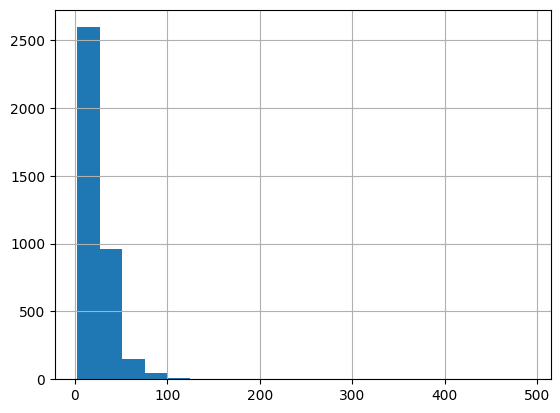

In [8]:
# wage
data_filtered[main_variables[0]].hist(bins=20)

<Axes: >

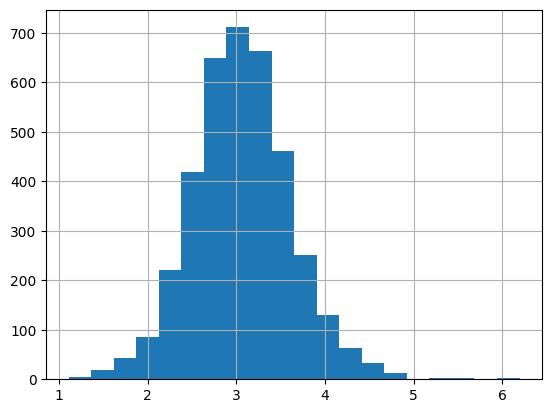

In [9]:
# lwage
data_filtered[main_variables[1]].hist(bins=20)

In [10]:
# sex
data_count_sex = (
    data_filtered["sex"].value_counts(normalize=True).round(4).reset_index()
)
data_count_sex["proportion"] = data_count_sex["proportion"] * 100
data_count_sex["percent"] = data_count_sex["proportion"].apply(lambda x: str(x) + " %")
data_count_sex

,sex,proportion,percent
0,0.0,51.09,51.09 %
1,1.0,48.91,48.91 %


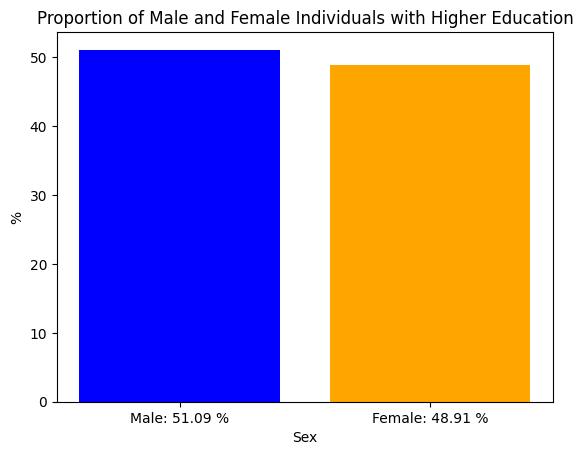

In [11]:
bars = plt.bar(
    data_count_sex["sex"], data_count_sex["proportion"], color=["blue", "orange"]
)
_percent = data_count_sex["percent"]
_title_sex = "Proportion of Male and Female Individuals with Higher Education"
plt.title(_title_sex)
plt.xlabel("Sex")
plt.ylabel("%")
labels = ["Male", "Female"]
sex_label = [x + ": " + p for x, p in zip(labels, _percent)]
plt.xticks(labels=sex_label, ticks=[0, 1])
plt.show()

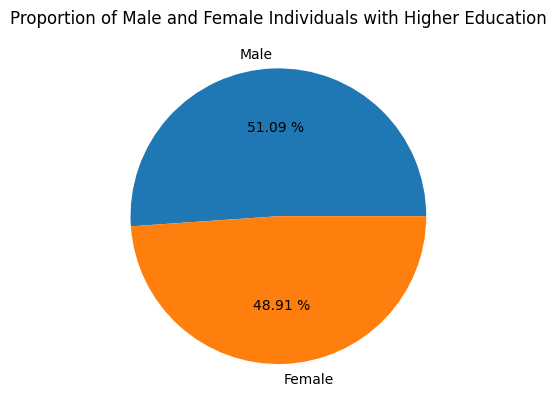

In [12]:
plt.pie(data_count_sex["proportion"], labels=labels, autopct="%.2f %%")
plt.title(_title_sex)
plt.show()

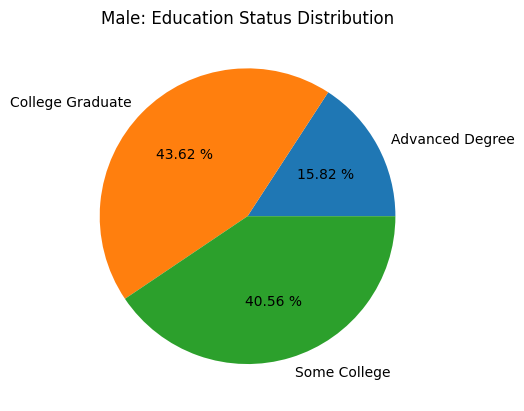

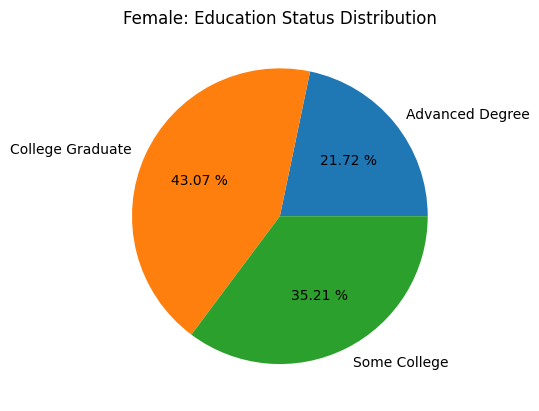

In [13]:
cat_edu = ["scl", "clg", "ad"]
cat_values = {"ad": "Advanced Degree", "clg": "College Graduate", "scl": "Some College"}
sex_cat = data_filtered[["sex"] + cat_edu].copy()
sex = ["Male", "Female"]
sex_cat["sex"].replace({1: sex[1], 0: sex[0]}, inplace=True)

sex_cat_ref = (
    sex_cat.melt(id_vars="sex", var_name="cat", value_name="count")
    .groupby(["sex", "cat"])
    .sum()
).reset_index()
sex_cat_ref.replace(cat_values, inplace=True)
sex_cat

for _sex in sex:
    _scat = sex_cat_ref.query("sex == @_sex")
    plt.pie(_scat["count"], labels=_scat["cat"], autopct="%.2f %%")
    plt.title(f"{_sex}: Education Status Distribution")
    plt.show()

In [14]:
cat_values

{'ad': 'Advanced Degree', 'clg': 'College Graduate', 'scl': 'Some College'}

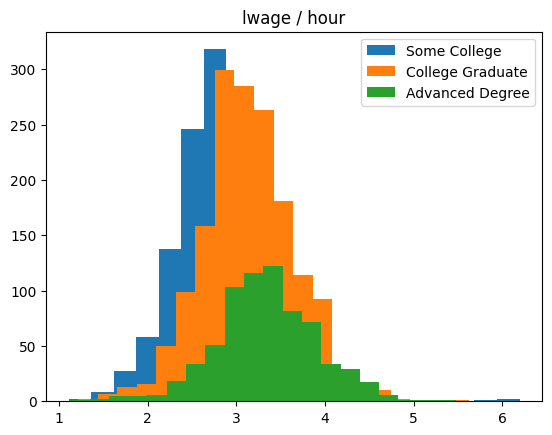

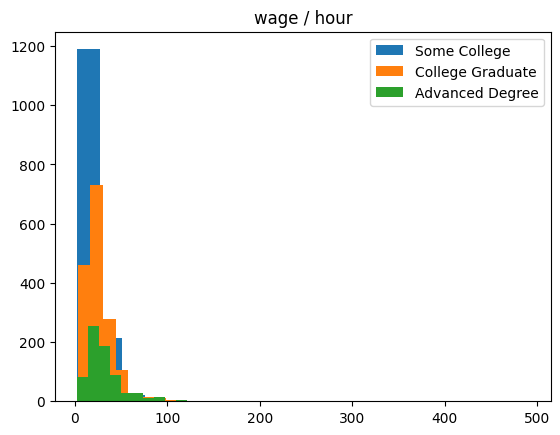

In [15]:
# Education, lwage
wage_var = ["lwage", "wage"]
edu_lwage = data_filtered[wage_var + cat_edu]

for wage in wage_var:
    fig, ax = plt.subplots()
    for _i_cat_edu in cat_edu:
        _df_cat_edu = edu_lwage[edu_lwage[_i_cat_edu] == 1][wage]
        ax.hist(_df_cat_edu, bins=20, label=cat_values.get(_i_cat_edu))
    plt.legend()
    plt.title(f"{wage} / hour")
    plt.show()

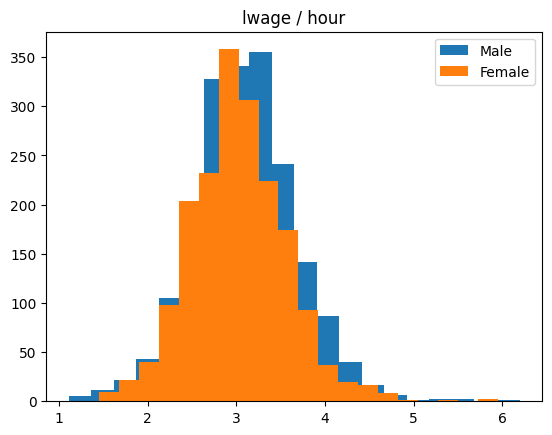

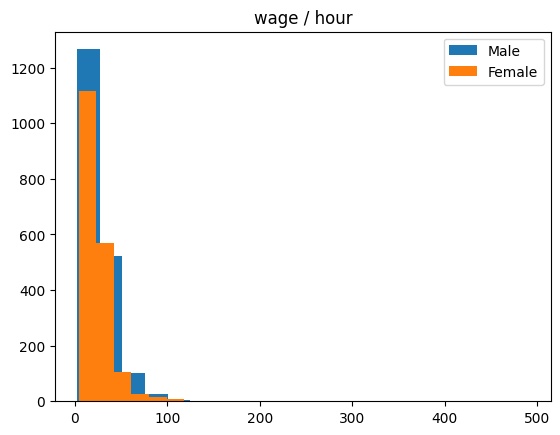

In [16]:
# sex, lwage, wage
sex_wage = data_filtered[wage_var + ["sex"]].copy()

sex_wage["sex"].replace({1: sex[1], 0: sex[0]}, inplace=True)
sex_wage

for wage in wage_var:
    fig, ax = plt.subplots()
    for _sex in sex:
        _df_cat_edu = sex_wage.query("sex == @_sex")[wage]
        ax.hist(_df_cat_edu, bins=20, label=_sex)
    plt.legend()
    plt.title(f"{wage} / hour")

# o

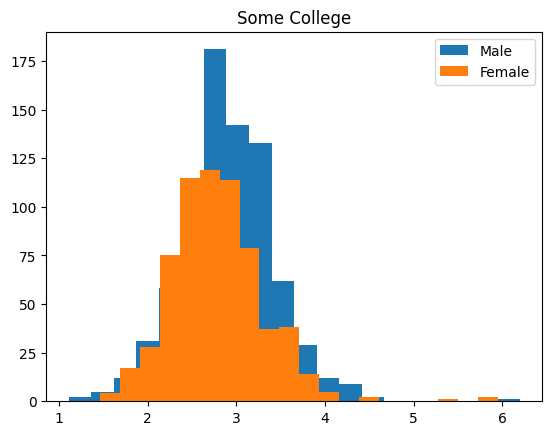

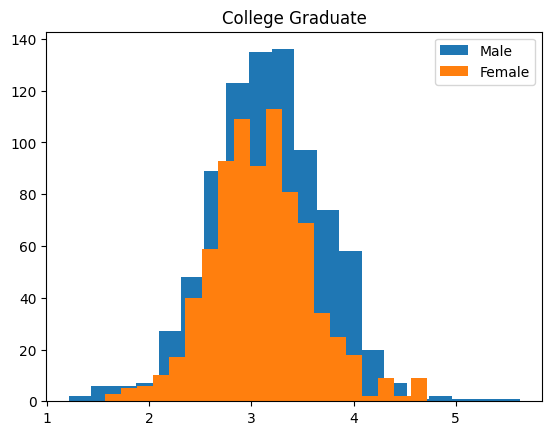

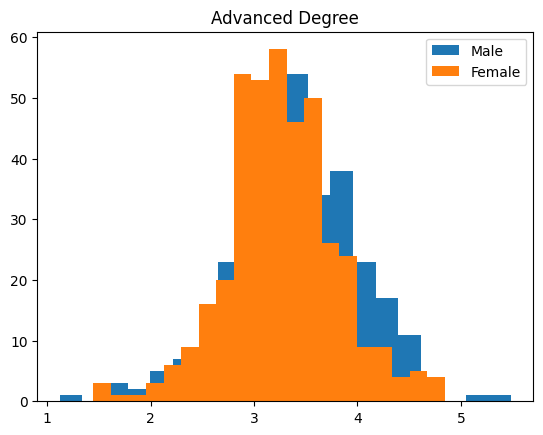

In [17]:
# sex, lwage, cat_education

edu_lwage_sex = data_filtered[wage_var + cat_edu + ["sex"]]
edu_lwage_sex["sex"].replace({1: sex[1], 0: sex[0]}, inplace=True)


edu_lwage_sex

for _i_cat_edu in cat_edu:
    # print(_i_cat_edu)
    fig, ax = plt.subplots()
    for _sex in sex:
        _df_edu_cat_sex = edu_lwage_sex[edu_lwage_sex[_i_cat_edu] == 1].query(
            "sex == @_sex"
        )["lwage"]
        # print(_df_edu_cat_sex)
        ax.hist(_df_edu_cat_sex, bins=20, label=_sex)
    plt.legend()
    plt.title(cat_values.get(_i_cat_edu))
    plt.show()

# Estimation


## Basic


In [18]:
# no control model
nc_md = smf.ols(formula="lwage~sex", data=data_filtered).fit()
nc_tbl: pd.DataFrame = nc_md.summary2().tables[1]
b1_est = nc_tbl["Coef."]["sex"]
b1_se = nc_tbl["Std.Err."]["sex"]
print(f"Beta:\t{b1_est}\nSE:\t{b1_se}")

Beta:	-0.07503200512595737
SE:	0.018373837141543274


In [19]:
# view
comp_df = pd.DataFrame()


def add_tbl(tbl: pd.DataFrame, type):
    global comp_df
    tbl = tbl.assign(type_md=type)
    comp_df = pd.concat((comp_df, tbl))

In [20]:
cols_table = ["type", "coef", "std", "t", "p", "lb", "up"]
nc_tbl = nc_tbl.reset_index()

nc_tbl.columns = cols_table
nc_tbl.iloc[1:2]

,type,coef,std,t,p,lb,up
1,sex,-0.075032,0.018374,-4.083633,0.000045,-0.111056,-0.039008


(-0.11105562342754156, 0.0)

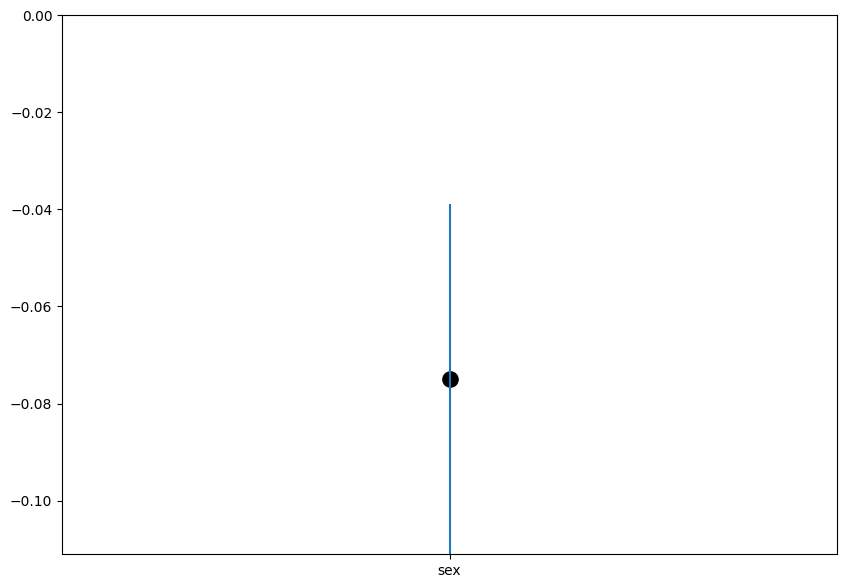

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))
target = nc_tbl.iloc[1:2]
add_tbl(target, "Basic")
ci = target[["lb", "up"]].values[0]
# ci
plt.plot([0, 0], ci)
ax.scatter(x=["sex"], y=b1_est, s=120, color="black")
plt.ylim((min(ci), 0))

## With Controls


In [22]:
flex = "lwage ~ sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"

# The smf api replicates R script when it transform data
control_model = smf.ols(formula=flex, data=data_filtered).fit().summary2()
# control_model

In [23]:
target = control_model.tables[1].reset_index().query('index == "sex"')
target.columns = cols_table
add_tbl(target, "W_controls")
target

,type,coef,std,t,p,lb,up
42,sex,-0.067634,0.017476,-3.869995,0.000111,-0.101899,-0.033369


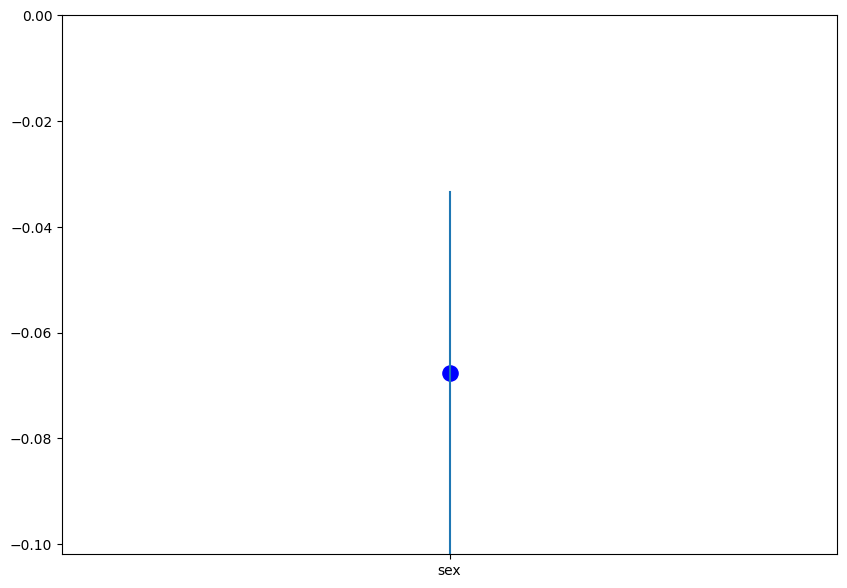

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
# target = nc_tbl.iloc[1:2]
ci = target[["lb", "up", "coef"]].values[0]
#
plt.plot([0, 0], ci[:2])
ax.scatter(x=["sex"], y=ci[2], s=120, color="blue")
plt.ylim((min(ci), 0))
plt.show()

## Partiallling Out


In [25]:
flex_y = "lwage ~  (exp1+exp2+exp3+exp4)*(scl+clg+ad+occ2+ind2+mw+so+we)"
flex_d = "sex ~ (exp1+exp2+exp3+exp4)*(scl+clg+ad+occ2+ind2+mw+so+we)"

t_Y = smf.ols(formula=flex_y, data=data_filtered).fit().resid

t_D = smf.ols(formula=flex_d, data=data_filtered).fit().resid

data_res = pd.DataFrame({"t_Y": t_Y, "t_D": t_D})

partial_fit = smf.ols(formula="t_Y ~ t_D", data=data_res).fit()
target = partial_fit.summary2().tables[1].reset_index().iloc[1:2]
target.columns = cols_table
add_tbl(target, "p_out")
target

,type,coef,std,t,p,lb,up
1,t_D,-0.067634,0.016928,-3.99536,0.000066,-0.100823,-0.034445


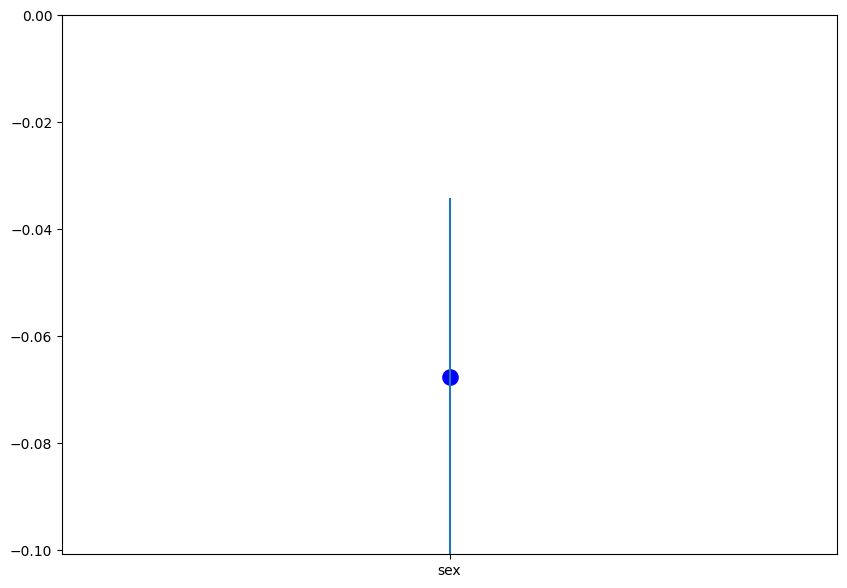

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))
ci = target[["lb", "up", "coef"]].values[0]
plt.plot([0, 0], ci[:2])
ax.scatter(x=["sex"], y=ci[2], s=120, color="blue")
plt.ylim((min(ci), 0))
plt.show()

## Models


In [27]:
comp_df

,type,coef,std,t,p,lb,up,type_md
1,sex,-0.075032,0.018374,-4.083633,0.000045,-0.111056,-0.039008,Basic
42,sex,-0.067634,0.017476,-3.869995,0.000111,-0.101899,-0.033369,W_controls
1,t_D,-0.067634,0.016928,-3.995360,0.000066,-0.100823,-0.034445,p_out


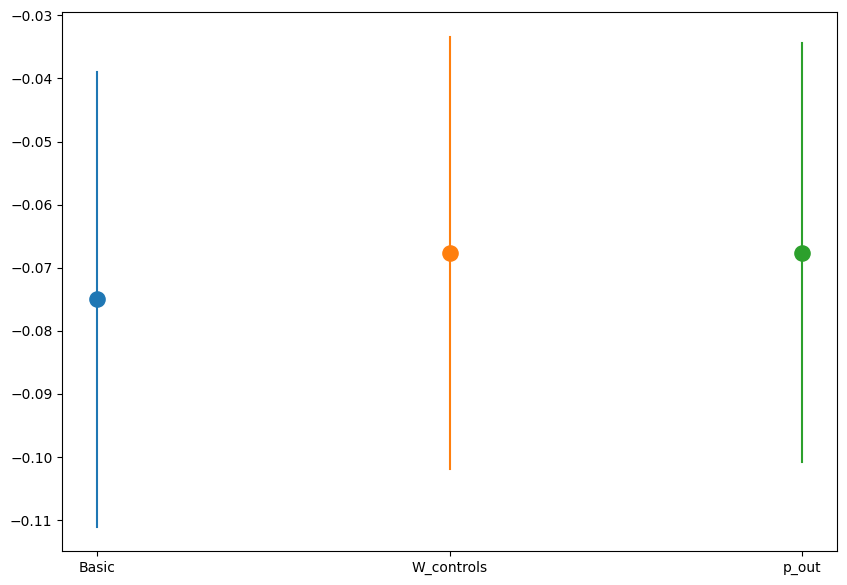

In [28]:
# plt.scatter("type_md", "coef", data = comp_df)
fig, ax = plt.subplots(figsize=(10, 7))
for _type in comp_df.type_md.values:
    ci_v = comp_df.query("type_md == @_type")[["lb", "up", "type_md", "coef"]].values[0]
    ax.scatter(x=_type, y=ci_v[3], s=120)
    plt.plot([ci_v[2], ci_v[2]], ci_v[:2])
# plt.plot()

# Replication: Male and Female

## Male

In [33]:
type_education = ["clg", "hsg"]

MODEL = "lwage ~ sex + (exp1+exp2+exp3+exp4)*(scl+clg+ad+occ2+ind2+mw+so+we)"


def predict(type_edu, sex=0, model=MODEL, data=data, group="exp1"):
    ref_data = data.query("sex == @sex")[data[type_edu] == 1]
    fitted_model = smf.ols(model, data=ref_data).fit()
    # col_name = f"predict_{type_edu}_sex_{sex}"
    col_name = f"predict"
    ref_data[col_name] = fitted_model.predict(ref_data)

    mean_exp1 = ref_data[[group, "lwage", col_name]].groupby(group).mean().reset_index()

    return mean_exp1


clg_male_mean = predict("clg", 0)
hsg_male_mean = predict("hsg", 0)
hsg_male_mean.head(2)

,exp1,lwage,predict
0,5.0,2.615219,2.597271
1,6.0,2.669723,2.691433


In [34]:
clg_male_mean.head(2)

,exp1,lwage,predict
0,1.0,3.080935,3.084459
1,2.0,3.108572,3.087025


In [54]:

intersection = np.intersect1d(hsg_male_mean['exp1'], clg_male_mean['exp1'])
hsg_male_in_gap = hsg_male_mean.query("exp1 in @intersection")
clg_male_in_gap = clg_male_mean.query("exp1 in @intersection")


def gap_values(col, clg_df, hsg_df):
    gap = clg_df[col].values - hsg_df[col].values
    return gap


predicted_gap_male = gap_values("predict", clg_male_in_gap, hsg_male_in_gap)
actual_gap_male = gap_values("lwage", clg_male_in_gap, hsg_male_in_gap)
std_gap_male = actual_gap_male.std()

gap_df = pd.DataFrame(
    {
        "exp1": intersection,
        "predict": predicted_gap_male,
        "ll": actual_gap_male - std_gap_male,
        "ul": actual_gap_male + std_gap_male,
    }
)
gap_df.head(2)

,exp1,predict,ll,ul
0,5.0,0.524652,0.038760,0.912672
1,6.0,0.427259,0.035941,0.909853


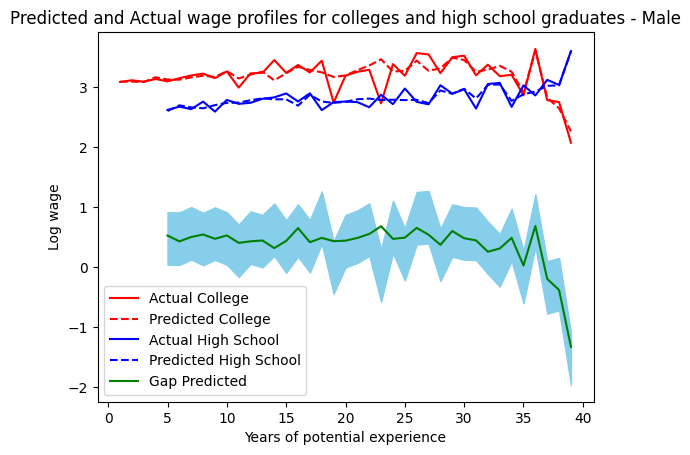

In [64]:
colors = ["red", "blue", "green", "skyblue"]
plt.plot("exp1", "lwage", c=colors[0], data=clg_male_mean, label="Actual College")
plt.plot(
    "exp1",
    "predict",
    c=colors[0],
    linestyle="--",
    data=clg_male_mean,
    label="Predicted College",
)

plt.plot("exp1", "lwage", c=colors[1], data=hsg_male_in_gap, label="Actual High School")
plt.plot(
    "exp1",
    "predict",
    c=colors[1],
    linestyle="--",
    data=hsg_male_in_gap,
    label="Predicted High School",
)

plt.plot("exp1", "predict", c=colors[2], data=gap_df, label="Gap Predicted")
plt.fill_between("exp1", "ll", "ul", data=gap_df, color=colors[3])


plt.xlabel("Years of potential experience")
plt.ylabel("Log wage")
plt.title(
    "Predicted and Actual wage profiles for colleges and high school graduates - Male"
)
plt.legend()
plt.show()

## Female

In [60]:

clg_female_mean = predict("clg", 1) # female
hsg_female_mean = predict("hsg", 1)


intersection = np.intersect1d(clg_female_mean['exp1'], hsg_female_mean['exp1'])
hsg_female_in_gap = hsg_female_mean.query("exp1 in @intersection")
clg_female_in_gap = clg_female_mean.query("exp1 in @intersection")

predicted_gap_female = gap_values("predict", clg_female_in_gap, hsg_female_in_gap)
actual_gap_female = gap_values("lwage", clg_female_in_gap, hsg_female_in_gap)
std_gap_female = actual_gap_female.std()

gap_df_female = pd.DataFrame(
    {
        "exp1": intersection,
        "predict": predicted_gap_female,
        "ll": actual_gap_female - std_gap_female,
        "ul": actual_gap_female + std_gap_female,
    }
)



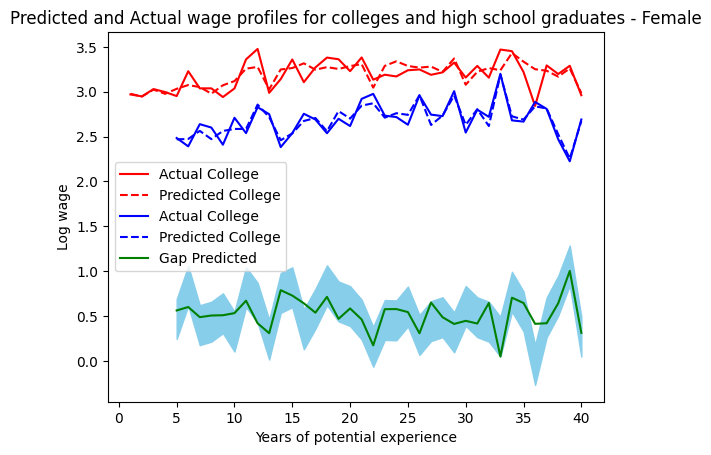

In [70]:
plt.plot("exp1", "lwage", c=colors[0], data=clg_female_mean, label="Actual College")
plt.plot(
    "exp1",
    "predict",
    c=colors[0],
    linestyle="--",
    data=clg_female_mean,
    label="Predicted College",
)

plt.plot("exp1", "lwage", c=colors[1], data=hsg_female_in_gap, label="Actual College")
plt.plot(
    "exp1",
    "predict",
    c=colors[1],
    linestyle="--",
    data=hsg_female_in_gap,
    label="Predicted College",
)

plt.plot("exp1", "predict", c=colors[2], data=gap_df_female, label="Gap Predicted")
plt.fill_between("exp1", "ll", "ul", data=gap_df_female, color=colors[3])


plt.xlabel("Years of potential experience")
plt.ylabel("Log wage")
plt.title(
    "Predicted and Actual wage profiles for colleges and high school graduates - Female"
)
plt.legend()
plt.show();

# Cross-Validation 

In [74]:
# alphas
_alphas = np.arange(0.1, 0.6, 0.1)
np.random.seed(21)

In [78]:
# folds
_kf = KFold(n_splits=len(_alphas), shuffle=True)
fold_i = [
    (train_i, test_i) for train_i, test_i in _kf.split(data)
]
# mse

mse_zeros = np.zeros((len(_alphas), len(_alphas)))

In [119]:
# Estimates, y: lwage
data_s = data.drop(columns=['rownames', 'wage'])

for i, alpha in enumerate(_alphas):
    for fold, (train_index, test_index) in enumerate(fold_i):
        X_train = data_s.iloc[train_index, 1:].values
        y_train = data_s.iloc[train_index, 0].values
        X_test  = data_s.iloc[test_index, 1:].values
        y_test  = data_s.iloc[test_index, 0].values

        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse_zeros[i, fold] = mean_squared_error(y_test, y_pred)


avg_mse = np.mean(mse_zeros, axis=1)

avg_mse

array([0.28461481, 0.28757758, 0.29138146, 0.29386058, 0.29602617,
       0.29867693, 0.3018129 , 0.30543407, 0.30954044])

In [137]:
i_best = np.argmin(avg_mse)
optimal_alpha = _alphas[i_best]
mse_best = avg_mse[i_best]
optimal_alpha

0.1


Best alpha: 0.1  MSE: 0.28461480572047787


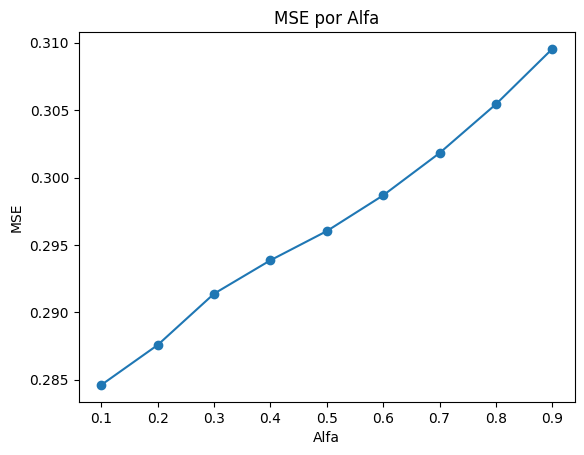

In [141]:
plt.figure()
plt.plot(_alphas, avg_mse, marker='o')
plt.title('MSE por Alfa')
plt.xlabel('Alfa')
plt.ylabel('MSE');

print(f'\nBest alpha: {optimal_alpha}  MSE: {mse_best}')

In [133]:
final_model = Lasso(alpha=optimal_alpha)
X = data_s.iloc[:, 1:]
y = data_s.iloc[:, 0]
final_model.fit(X.values, y.values)
final_predictions = final_model.predict(X.values)
final_mse = mean_squared_error(y.values, final_predictions)

final_mse, final_predictions[:6]


(0.28367990586735203,
 array([2.9182576 , 3.13628042, 2.8774957 , 3.33078933, 3.10164488,
        3.07991146]))